# Exploring Fraud Detection With Neo4j & Graph Data Science

This analysis uses [Neo4j and Graph Data Science (GDS)](https://neo4j.com/docs/graph-data-science/current/) to explore an anonymized data sample from a Peer-to-Peer (P2P) payment platform.  The notebook is split up into the following sections to cover various stages of the graph data science workflow:

- Notebook Setup
- Part 1: Exploring Connected Fraud Data
- Part 2: Resolving Fraud Communities using Entity Resolution and Community Detection
- Part 3: Recommending Suspicious Accounts With Centrality & Node Similarity
- Part 4: Predicting Fraud Risk Accounts with Machine Learning

## Notebook Setup <a name="p0"></a>

In [1]:
import pandas as pd
import configparser
import os
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 50)

### Neo4j Settings
The `NEO4J_PROPERTIES_FILE` is an ini configuration file for Neo4j properties so this notebook can connect to
your Neo4j instance and load data. The ini file should be formatted as follows
```
[NEO4J]
PASSWORD=<password>
USERNAME=<database name, is 'neo4j' by default>
HOST=<host uri>
```

Set `NEO4J_PROPERTIES_FILE` to None or any non-existent location to use the below defaults
```
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'
```

In [2]:
NEO4J_PROPERTIES_FILE = '/Users/zachblumenfeld/devtools/auth/aura-p2p-fd.ini'

In [3]:
## Using an ini file for credentials, otherwise providing defaults
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'

if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_PROPERTIES_FILE)
    HOST = config['NEO4J']['HOST']
    USERNAME = config['NEO4J']['USERNAME']
    PASSWORD = config['NEO4J']['PASSWORD']
    print('Using custom database properties')
else:
    print('Could not find database properties file, using defaults')

Using custom database properties


### Connect to Graph Data Science

In [4]:
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience(HOST, auth=(USERNAME, PASSWORD), aura_ds=True)

### Helper Functions

In [5]:
def clear_graph_by_name(g_name):
    if gds.graph.exists(g_name).exists:
        g = gds.graph.get(g_name)
        gds.graph.drop(g)

def clear_all_graphs():
    g_names = gds.graph.list().graphName.tolist()
    for g_name in g_names:
        g = gds.graph.get(g_name)
        gds.graph.drop(g)

def identifier_degrees(user_label, degree_property):
    g_name = 'id-projection'
    clear_graph_by_name(g_name)
    g, _  = gds.graph.project(g_name, [user_label, 'Card', 'Device', 'IP'],{
        'HAS_CC': {'orientation': 'REVERSE'},
        'HAS_IP': {'orientation': 'REVERSE'},
        'USED': {'orientation': 'REVERSE'}
    })
    gds.degree.mutate(g, mutateProperty=degree_property)
    gds.graph.writeNodeProperties(g, [degree_property], ['Card', 'Device', 'IP'])
    g.drop()

## Part 1: Exploring Connected Fraud Data

### Dataset Introduction

We will be using an anonymized sample of user accounts and transactions from a real-world Peer-to-Peer (P2P) platform. Prior to ingesting the data into graph, the original identification numbers were removed and categorical values were masked. Each user account has a unique 128-bit identifier, while the other nodes, representing unique credit cards, devices, and ip addresses have been assigned random UUIDs. These identifier are stored as the guid property in the graph schema.

Below is a visualization of the graph schema:

<img src="img/schema.png" width="500" >

Each user node has an indicator variable for money transfer fraud (named MoneyTransferFraud) that is 1 for known fraud and 0 otherwise. This indicator is determined by a combination of credit card chargeback events and manual review. A chargeback is an action taken by a bank to reverse electronic payments. It involves reversing a payment and triggering a dispute resolution process, often for billing errors and unauthorized credit use. In short, a user must have at least one chargeback to be considered fraudulent. Only a small proportion of the user accounts, roughly 0.7 %, are flagged for fraud.

Each user node has an indicator variable for money transfer fraud (named `MoneyTransferFraud`) that is 1 for known fraud and 0 otherwise. This indicator is determined by a combination of credit card chargeback events and manual review. A chargeback is an action taken by a bank to reverse electronic payments. It involves reversing a payment and triggering a dispute resolution process, often for billing errors and unauthorized credit use. In short, a user must have at least one chargeback to be considered fraudulent. Only a small proportion of the user accounts, roughly 0.7 %, are flagged for fraud.


Below is a breakdown of high-level counts by labels and relationships as well as the flagged accounts.

In [7]:
# total node counts
gds.run_cypher('''
    CALL apoc.meta.stats()
    YIELD labels
    UNWIND keys(labels) AS nodeLabel
    RETURN nodeLabel, labels[nodeLabel] AS nodeCount
''')

,nodeLabel,nodeCount
0,User,33732
1,Device,51451
2,Card,118818
3,IP,585855


In [8]:
# total relationship counts
gds.run_cypher('''
    CALL apoc.meta.stats()
    YIELD relTypesCount
    UNWIND keys(relTypesCount) AS relationshipType
    RETURN relationshipType, relTypesCount[relationshipType] AS relationshipCount
''')

,relationshipType,relationshipCount
0,USED,55026
1,HAS_IP,1488949
2,HAS_CC,128066
3,REFERRED,1870
4,P2P,102832


In [9]:
#fraud money transfer flags
gds.run_cypher('MATCH(u:User) RETURN u.fraudMoneyTransfer AS fraudMoneyTransfer, count(u) AS cnt')

,fraudMoneyTransfer,cnt
0,0,33491
1,1,241


### A Closer Look at Cards and Devices

Upon an initial investigation of aggregate statistics, the labeled fraud accounts do not look well connected which would naturally make one skeptical of a graph based approach.  This is exemplified well by the lack of discrimination in key identifiers.

As a first step, I break out the ratio of fraud vs non-fraud users connected to credit cards and devices below. I find that very few cards or devices are centered well around flagged accounts. This is a bit surprising for me. If a card or device is used by a flagged account, I would expect the other accounts that use the card/device to also be mostly flagged for fraud as well.

In [10]:
# Setting a label for flagged users will enable faster lookups in cypher and faster gds projections
gds.run_cypher('MATCH(u:User) WHERE u.fraudMoneyTransfer=1 SET u:FlaggedUser RETURN count(u)')

,count(u)
0,241


In [11]:
# Use GDS degree centrality to count the number of Users connected to each identifier type - Card, Device, IP
identifier_degrees('User', 'degree')
# Use GDS degree centrality to count the number of FLAGGED Users connected to each identifier type - Card, Device, IP
identifier_degrees('FlaggedUser', 'flaggedDegree')

# Calculate the ratio of flagged users to total users
gds.run_cypher('''
    MATCH(n) WHERE n:Card OR n:Device OR n:IP
    SET n.flaggedRatio = toFloat(n.flaggedDegree)/toFloat(n.degree)
''')

""


In [12]:
print('Flagged User Ratio for Card Count')
gds.run_cypher('''
    MATCH(n:Card) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH(n:Card) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.flaggedRatio=0 THEN '0'
        WHEN n.flaggedRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS flaggedUserRatio
    RETURN flaggedUserRatio, count(n) AS count, round(toFloat(count(n))/total,3) AS percentCount 
    ORDER BY flaggedUserRatio
''')

Flagged User Ratio for Card Count


,flaggedUserRatio,count,percentCount
0,0,8185,0.964
1,1,31,0.004
2,Between 0-1,274,0.032


In [13]:
print('Flagged User Ratio for Device Count')
gds.run_cypher('''
    MATCH(n:Device) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH(n:Device) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.flaggedRatio=0 THEN '0'
        WHEN n.flaggedRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS flaggedUserRatio
    RETURN flaggedUserRatio, count(n) AS count, round(toFloat(count(n))/total,3) AS percentCount 
    ORDER BY flaggedUserRatio
''')

Flagged User Ratio for Device Count


,flaggedUserRatio,count,percentCount
0,0,2655,0.967
1,1,2,0.001
2,Between 0-1,88,0.032


#### Exploring Potential Fraud Patterns with Community Detection

In this example, it is unclear to me what exactly is taking place, and I have a hunch that the fraud activity is not completely labeled given the lack of connectivity and the limited chargeback logic used to flag fraud. At the same time I do not want to simply label every user that shares a card or device with another flagged account, since it is possible that a benign user's device and or card was used fraudulently by another. Since fraudsters are actively avoiding being identified, actors committing fraud are often not just represented by a single user account, but rather by multiple accounts and identifiers which, hopefully for us, share some connections and similarities.

In a graph, we can attempt to roughly identify these fragmented identities with Community Detection, a large set of methods that attempt to partition graphs into well connected groups a.k.a. Communities, where the connectivity in the communities is significantly higher than outside the community. There are multiple forms of community detection. We will use a couple in this post, starting with Louvain.

#### Using Louvain Community Detection

[Louvain](https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/) is useful for exploratory analysis of communities because it uses a form of modularity scoring to split up the graph into hierarchical clusters. This means that your theories around fraud patterns and graph structure don't need to be exact for it to provide informative communities and insights.

I will leverage P2P transactions, cards, and devices for Louvain. We will leave out IP addresses for now since they have some super node issues (we will leverage IP addresses in subsequent parts ). Below are the queries for running Louvain in Neo4j GDS and aggregating community statistics. The last query below orders communities by the count of flagged users so we can further examine some of the more concentrated flagged communities.


In [14]:
# clear the graph if it exists beforehand
clear_graph_by_name('comm-projection')

g, _ = gds.graph.project('comm-projection', ['User','Card', 'Device'], {
    'HAS_CC': {'orientation': 'UNDIRECTED'},
    'USED': {'orientation': 'UNDIRECTED'},
    'P2P': {'orientation': 'NATURAL', 'aggregation': 'SINGLE'}
})

df = gds.louvain.write(g, writeProperty='louvainCommunityId')
g.drop()
df

writeMillis                                                                                                                                                                                                                                                                                                                                                                    411
nodePropertiesWritten                                                                                                                                                                                                                                                                                                                                                       204001
modularity                                                                                                                                                                                                                                                        

In [15]:
print("Louvain Communities Ordered by count of Flagged Users")
gds.run_cypher('''
    MATCH (u:User)
    WITH u.louvainCommunityId AS community,
        count(u) AS cnt,
        sum(u.fraudMoneyTransfer) as flaggedCount
    RETURN community,
        cnt,
        flaggedCount,
        toFloat(flaggedCount)/toFloat(cnt) AS flaggedRatio
    ORDER BY flaggedCount DESC LIMIT 100
''')

Louvain Communities Ordered by count of Flagged Users


,community,cnt,flaggedCount,flaggedRatio
0,89885,27,5,0.185185
1,182733,7,4,0.571429
2,179565,3,3,1.000000
3,188313,6,3,0.500000
4,201222,7,3,0.428571
...,...,...,...,...
95,170654,2,1,0.500000
96,172960,2,1,0.500000
97,94447,5,1,0.200000
98,194173,3,1,0.333333


We can view communities of users and connecting identifiers in [Neo4j Bloom](https://neo4j.com/docs/bloom-user-guide/current/) or Neo4j Browser with queries of the form:

```cypher
MATCH(u1:User{louvainCommunityId: $id})-[r1:HAS_CC|HAS_IP|USED]->(n)<-[r2:HAS_CC|HAS_IP|USED]-(u2:User{louvainCommunityId: $id})
WITH *
OPTIONAL MATCH (u1)-[:P2P]-(u2)
RETURN *
```
Below are a couple examples of these communities. Flagged users are colored red with caption=0 with other users colored orange and caption=1. We will see an interesting pattern of flagged users sending money to non-flagged users with which they share devices, cards, and IPs. This behavior is suspicious because it suggests that the same individual or group of individuals may be using multiple accounts to withdraw cash from credit transactions prior to a chargeback being executed on the cards. The shared credit card examples (such as example 2 below) are some of the most indicative.

Example 1:
<img src="img/louvain-community-11.png" width="900" >

Example 2:
<img src="img/louvain-community-12.png" width="900" >

This pattern indicates that the receiving user accounts are fraud risk accounts. In the next section we will use these patterns to inform resolution of fraud communities and the labeling of additional fraud risk accounts.

## Part 2: Resolving Fraud Communities using Entity Resolution and Community Detection

Identifying communities that reflect underlying groups of individuals is often a key step to fraud detection.  We already explored with Louvain; in this section, in this part, we will provide more formal definitions for resolving entities that will allow us to partition well defined communities in a scalable manner.

To accomplish this, we will define some Entity Resolution (ER) rules that will allow us to draw relationships between users which we believe belong to the same underlying community. We will then use the [Weakly Connected Components (WCC)](https://neo4j.com/docs/graph-data-science/current/algorithms/wcc/) algorithm to resolve the communities. Lastly, we will label all users in communities that include flagged accounts as fraud risks.

### Entity Resolution Business Rules

We will now use Entity Resolution (ER) to resolve groups of individuals behind sets of user accounts. For this analysis, we will use some pretty straightforward ER business logic. If either of the two below conditions are true, we will resolve two user accounts by linking them together with a new relationship type.

1. One user sent money to another user that shares the same credit card
2. Two users share a card or device connected to less than or equal to 10 total accounts, and those two users also share at least two other identifiers of type credit card, device, or IP address

You could switch out or add different rules to the above, these are just examples. In a real-world scenario these business rules would pass by SMEs and possibly be backed by further supervised machine learning on manually labeled data. More advanced techniques for this type of ER are possible in graph and we describe them in [this whitepaper](https://neo4j.com/whitepapers/graph-data-science-use-cases-entity-resolution/) and [this blog](https://neo4j.com/developer-blog/exploring-supervised-entity-resolution-in-neo4j/).

For a P2P dataset, we do not necessarily want to label all senders/receivers of flagged user transactions as fraudulent since some fraud schemes involve transactions with victims. Furthermore, additional identifiers such as IP may be inexact and cards + devices can be fraudulently controlled/used without the owners permission. Hence I used somewhat stringent rules that aligned with the patterns noted in part 1. We can apply relationships to reflect these business rules using cypher:


In [16]:
# P2P with shared card rule
gds.run_cypher('''
    MATCH (u1:User)-[r:P2P]->(u2)
    WITH u1, u2, count(r) AS cnt
    MATCH (u1)-[:HAS_CC]->(n)<-[:HAS_CC]-(u2)
    WITH u1, u2, count(DISTINCT n) AS cnt
    MERGE(u1)-[s:P2P_WITH_SHARED_CARD]->(u2)
    RETURN count(DISTINCT s) AS cnt
''')

,cnt
0,6240


In [17]:
# Shared ids rule
gds.run_cypher('''
    MATCH (u1:User)-[:HAS_CC|USED]->(n)<-[:HAS_CC|USED]-(u2)
    WHERE n.degree <= 10 AND id(u1) < id(u2)
    WITH u1, u2, count(DISTINCT n) as cnt
    MATCH (u1)-[:HAS_CC|USED|HAS_IP]->(m)<-[:HAS_CC|USED|HAS_IP]-(u2)
    WITH u1, u2, count(DISTINCT m) as cnt
    WHERE cnt > 2
    MERGE(u1)-[s:SHARED_IDS]->(u2)
    RETURN count(DISTINCT s)
''')

,count(DISTINCT s)
0,5316


### Using Weakly Connected Components (WCC) to Resolve Communities

[Weakly Connected Components (WCC)](https://neo4j.com/docs/graph-data-science/current/algorithms/wcc/) is a practical and highly scalable community detection algorithm. It is also deterministic and very explainable. It defines a community simply as a set of nodes connected by a subset of relationship types in the graph. This makes WCC a good choice for formal community assignment in production fraud detection settings.

Below we run WCC on users via the ER relationships created above:


In [18]:
# clear the graph if it exists beforehand
clear_graph_by_name('comm-projection')

g, _ = gds.graph.project('comm-projection', ['User'], {
    'SHARED_IDS': {'orientation': 'UNDIRECTED'},
    'P2P_WITH_SHARED_CARD': {'orientation': 'UNDIRECTED'}
})

df = gds.wcc.write(g, writeProperty='wccId')
g.drop()
df

writeMillis                                                                                                                                                                                                                                                                      79
nodePropertiesWritten                                                                                                                                                                                                                                                         33732
componentCount                                                                                                                                                                                                                                                                28203
componentDistribution                                                                                                                                                {'p99':

### Labeling Fraud Risk User Accounts

As these communities are meant to label underlying groups of individuals, if even one flagged account is in the community, we will label all user accounts in the group as fraud risks:


In [19]:
gds.run_cypher('''
    MATCH (f:FlaggedUser)
    WITH collect(DISTINCT f.wccId) AS flaggedCommunities
    MATCH(u:User) WHERE u.wccId IN flaggedCommunities
    SET u:FraudRiskUser
    SET u.fraudRisk=1
    RETURN count(u)
''')

,count(u)
0,452


In [20]:
gds.run_cypher('''
    MATCH (u:User) WHERE NOT u:FraudRiskUser
    SET u.fraudRisk=0
    RETURN count(u)
''')

,count(u)
0,33280


### WCC Community Statistics

The breakdown of communities by size is listed below. The majority are single user communities. Only a small portion have multiple users and of those, community sizes are mostly 2 and 3. Larger communities are rare. However, if we look at the fraudUser accounts we will see that the majority reside in multi-user communities. The 118 fraud accounts in single user communities are flagged users (via original chargeback logic) that have yet to be resolved to a community.

In [21]:
gds.run_cypher( '''
    MATCH (u:User)
    WITH u.wccId AS community, count(u) AS cSize, sum(u.fraudRisk) AS cFraudSize
    WITH community, cSize, cFraudSize,
    CASE
        WHEN cSize=1 THEN ' 1'
        WHEN cSize=2 THEN ' 2'
        WHEN cSize=3 THEN ' 3'
        WHEN cSize>3 AND cSize<=10 THEN ' 4-10'
        WHEN cSize>10 AND cSize<=50 THEN '11-50'
        WHEN cSize>10 THEN '>50' END AS componentSize
    RETURN componentSize, 
        count(*) AS numberOfComponents, 
        sum(cSize) AS totalUserCount, 
        sum(cFraudSize) AS fraudUserCount 
    ORDER BY componentSize
''')

,componentSize,numberOfComponents,totalUserCount,fraudUserCount
0,1,24283,24283,118
1,2,3165,6330,144
2,3,481,1443,63
3,4-10,258,1246,68
4,11-50,15,255,59
5,>50,1,175,0


Similar to Louvain we can view communities of users and connecting identifiers in [Neo4j Bloom](https://neo4j.com/docs/bloom-user-guide/current/) or Browser with queries of the form:

```cypher
MATCH(u1:User{wccId: $id})-[r1:HAS_CC|HAS_IP|USED]->(n)<-[r2:HAS_CC|HAS_IP|USED]-(u2:User{wccId: $id})
WITH *
OPTIONAL MATCH (u1)-[r3:P2P]-(u2)
RETURN *
```
Below are a couple examples. Users that were flagged via initial chargeback logic are colored red with caption=1, while other users are colored orange with caption=0. Overall, you will notice a high degree of overlapping connectivity of identifiers and P2P transactions between users, which we should expect given our ER rules.

Example 1:
<img src="img/wcc-community-12.png" width="900" >

Example 2:
<img src="img/wcc-community-11.png" width="900" >

### Outcomes of Fraud Risk Labeling
Fraud Risk labeling helped identify an additional 211 new fraud risk user accounts, nearly doubling the number of known fraud users (87.5% increase). We also see that 65% of the money going to/from previously flagged accounts and other users can be attributed to the newly identified risk accounts:

In [22]:
gds.run_cypher('''
   MATCH (:FlaggedUser)-[r:P2P]-(u)  WHERE NOT u:FlaggedUser
   WITH toFloat(sum(r.totalAmount)) AS p2pTotal
   MATCH (u:FraudRiskUser)-[r:P2P]-(:FlaggedUser) WHERE NOT u:FlaggedUser
   WITH p2pTotal,  toFloat(sum(r.totalAmount)) AS fraudRiskP2pTotal
   RETURN round((fraudRiskP2pTotal)/p2pTotal,3) AS p
''').p[0]

0.652

Additionally, while the newly identified 211 accounts represents less than 1% of total users in the sample, 12.7% of the total P2P amount in the sample involved the newly identified accounts as senders or receivers:

In [23]:
gds.run_cypher('''
   MATCH (:User)-[r:P2P]->()
   WITH toFloat(sum(r.totalAmount)) AS p2pTotal
   MATCH (u:FraudRiskUser)-[r:P2P]-() WHERE NOT u:FlaggedUser
   WITH p2pTotal, toFloat(sum(r.totalAmount)) AS fraudRiskP2pTotal
   RETURN round((fraudRiskP2pTotal)/p2pTotal,3) AS p
''').p[0]

0.127

Finally, we can see an improvement in card and device discrimination with many more cards and devices being used by fraud risk accounts exclusively.

In [24]:
identifier_degrees('FraudRiskUser', 'fraudRiskDegree')

gds.run_cypher('''
    MATCH(n) WHERE n:Card OR n:Device OR n:IP
    SET n.fraudRiskRatio = toFloat(n.fraudRiskDegree)/toFloat(n.degree)
''')

""


In [25]:
gds.run_cypher('''
    MATCH(n:Card) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH(n:Card) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.fraudRiskRatio=0 THEN '0'
        WHEN n.fraudRiskRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS fraudRiskRatio
    RETURN fraudRiskRatio, count(n) AS count, round(toFloat(count(n))/total,3) AS percentCount 
    ORDER BY fraudRiskRatio
''')

,fraudRiskRatio,count,percentCount
0,0,8114,0.956
1,1,351,0.041
2,Between 0-1,25,0.003


In [26]:
gds.run_cypher('''
    MATCH(n:Device) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH(n:Device) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.fraudRiskRatio=0 THEN '0'
        WHEN n.fraudRiskRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS fraudRiskRatio
    RETURN fraudRiskRatio, count(n) AS count, round(toFloat(count(n))/total,3) AS percentCount 
    ORDER BY fraudRiskRatio
''')

,fraudRiskRatio,count,percentCount
0,0,2605,0.949
1,1,92,0.034
2,Between 0-1,48,0.017


The aggregate P2P statistics combined with improvements in Card and Device metrics are significant given the limited scope of the previously flagged fraud which focused on chargebacks.  These results strongly imply that there are more sophisticated networks of fraudulent money flows behind the chargebacks rather than the chargebacks being isolated occurrences.

## Part 3: Recommending Suspicious Accounts With Centrality & Node Similarity

In parts 1 & 2 we explored the graph and identified high risk fraud communities. At this stage, we may want to expand beyond our business logic to automatically identify other users that are suspiciously similar to the fraud risks already identified. Neo4j and GDS makes it simple to triage and recommend such suspect users in a matter of seconds. We can leverage both centrality and similarity algorithms for this.


### Using Weighted Degree Centrality to Recommend Potential High Risk Accounts

We can quickly and easily generate a ranked list of suspicious user accounts with weighted degree centrality. Specifically, we can calculate the degree centrality of users in respect to their identifiers (Devices, Cards, and IPs) weighted by the fraudRiskRatios we made in part 2. In this case, a simple Cypher query suffices.


In [27]:
gds.run_cypher('''
    MATCH(f:FraudRiskUser)-[:HAS_CC|HAS_IP|USED]->(n)
    WITH DISTINCT n
    MATCH(u:User)-[:HAS_CC|HAS_IP|USED]->(n) WHERE NOT u:FraudRiskUser
    WITH left(u.guid,8) as uid,
        sum(n.fraudRiskRatio) AS totalIdFraudRisk,
        count(n) AS numberFraudRiskIds
    WITH uid, totalIdFraudRisk,
        numberFraudRiskIds,
        totalIdFraudRisk/toFloat(numberFraudRiskIds) AS averageFraudIdRisk
    WHERE averageFraudIdRisk >= 0.25
    RETURN uid, totalIdFraudRisk, numberFraudRiskIds, averageFraudIdRisk
    ORDER BY totalIdFraudRisk DESC LIMIT 10
''')

,uid,totalIdFraudRisk,numberFraudRiskIds,averageFraudIdRisk
0,50fd11c0,7.405512,28,0.264483
1,b41b9e3b,6.487978,22,0.294908
2,a982e8fc,3.928543,13,0.302196
3,60b71ab9,2.020481,7,0.288640
4,bc1eb835,2.010309,5,0.402062
5,1b1a78a9,1.925455,5,0.385091
6,f2b8a068,1.693794,6,0.282299
7,1c773976,1.594978,5,0.318996
8,a2f748e3,1.570455,4,0.392614
9,7524a090,1.527338,5,0.305468


Users in the above result list are sorted by how much identifying information they share with previously labeled fraud risks, the ones with the most being at the top. Technically speaking, these users are ranked by their total Id fraud risk, which is equal to the sum of the fraudRiskRatios from the Identifiers they are connected to. In the query I also implement a limit on the average fraud risk to avoid users that just have a lot of high-degree identifiers (likely proxy ip addresses shared by only a small fraction of fraud risk users). This sort of filtering can be tweaked by use case to get the right balance between total risk vs average risk.

In a real-world fraud detection use case, these results can be triaged by analysts to label more fraud accounts and grow labeled fraud communities.

### Using Node Similarity to Expand on Fraud Communities

Simple calculations like weighted degree centrality work well for identifying suspicious users over the whole graph, but what if we are interested in how users are related to a specific fraud risk community or set of communities? Perhaps we hypothesize that communities of fraud risk users are actually bigger than currently represented but we don't have exact business rules to apply. We can leverage similarity algorithms to help us score and recommend users for this.

GDS offers multiple algorithms for similarity. In this analysis I will focus on the aptly named  Node Similarity algorithm – you can read more about it [here](https://neo4j.com/docs/graph-data-science/current/algorithms/node-similarity/). Node similarity parallelizes well and is explainable. It identifies pairs of similar nodes based on a straightforward Jaccard similarity calculation. So while other ML-based similarity approaches like FastRP + KNN covered [in this post](https://neo4j.com/developer-blog/exploring-practical-recommendation-systems-in-neo4j/) scale well for running globally on very large graphs, Node Similarity is a good choice where explainability is important and you can narrow down the universe of comparisons to a subset of your data. Examples of narrowing down include focusing on just single communities, newly added users, or users within a specific proximity to suspect accounts. In this analysis we will take the third approach, filtering to just those Cards, Devices, and IP addresses that connect to at least one fraud risk account from part 2.


Below I apply three queries to calculate node similarity. The first query enables the identifier filtering via setting a new label on the Card, Device, and IP address nodes that connect to fraud risk accounts. The first query also weights relationships by the inverse of degree centrality, essentially downplaying the importance of identifiers proportional to the number of other users they connect to. This is important as some identifiers, particularly IP addresses, can connect to hundreds or thousands of users, in which case the identifier may be very generic (like a proxy IP address) and not as relevant to true user identity. The second and third query project the graph and write relationships back to the database with a score to represent similarity strength between user node pairs. You will notice that I use a similarity cutoff of 0.01 in the third query, which is intended to rule out weak associations and keep the similarities relevant.


In [28]:
# label identifiers and users that are close to fraud risk users and assign inverse degree weight
gds.run_cypher('''
    MATCH(f:FraudRiskUser)-[:HAS_CC|HAS_IP|USED]->(n)
    WITH DISTINCT n
    MATCH(n)<-[r:HAS_CC|HAS_IP|USED]-(u)
    SET n:FraudSharedId
    SET r.inverseDegreeWeight = 1.0/(n.degree-1.0)
    RETURN count(DISTINCT n)
''')

,count(DISTINCT n)
0,18182


In [29]:
# clear the graph if it exists beforehand
clear_graph_by_name('similarity-projection')

g, _ = gds.graph.project('similarity-projection', ['User', 'FraudSharedId'], ['HAS_CC', 'USED', 'HAS_IP'],
                         relationshipProperties=['inverseDegreeWeight'])



df = gds.nodeSimilarity.write(g, writeRelationshipType='SIMILAR_IDS', writeProperty='score',
                              similarityCutoff=0.01, relationshipWeightProperty='inverseDegreeWeight')
g.drop()
df

preProcessingMillis                                                                                                                                                                                                                                                                                                                                                                                                           0
computeMillis                                                                                                                                                                                                                                                                                                                                                                                                             71320
writeMillis                                                                                                                                                             

From there, we can run a Cypher query to rank users by how similar they are to known fraud risk communities.

In [30]:
#get nodes similar to the high risk ones
gds.run_cypher('''
    MATCH (f:FraudRiskUser)
    WITH f.wccId AS componentId, count(*) AS numberOfUsers, collect(f) AS users
    UNWIND users AS f
    MATCH (f)-[s:SIMILAR_IDS]->(u:User) WHERE NOT u:FraudRiskUser AND numberOfUsers > 2
    RETURN u.guid AS userId, sum(s.score) AS totalScore, collect(DISTINCT componentId) AS closeToCommunityIds 
    ORDER BY totalScore DESC
''')

,userId,totalScore,closeToCommunityIds
0,0b3f278ff6b348fb1a599479d9321cd9,0.427332,"[4616, 4932]"
1,c0d80bb57c0bbb0b68f647c7adc83274,0.298319,[4932]
2,99d857cf888723db4ab2c19e42ac2b4c,0.260633,[4616]
3,6b41e66c7667df06c10eab6c6b712fec,0.201825,[4932]
4,55447b3000b48335d3b18557c43ba70a,0.136346,[4616]
5,8c7fb38c22da0e7ad8d91a8551f62e4c,0.136169,[433]
6,f0ec0c4c8cf74ebdf1ace4c366e58873,0.111970,[4616]
7,f3c3fa16c8d095c257452f3287991cef,0.082760,[4616]
8,48ab157818d5d6e31d4808e624a93846,0.077805,[4616]
9,a2f748e3e52915b9aff50f9af628a9ee,0.075465,[433]


Let’s take a look at the first user in the list, user `0b3f278f`, in [Bloom](https://neo4j.com/docs/bloom-user-guide/current/) . This user account seems interesting in the sense that they connect to two different communities.

<img src="img/node-similarity-1.png" width="700" >

You can see how this user connects to the two fraud risk communities and how the similarity relationships were based on shared IP addresses. This user seems to act as a sort of bridge between the two communities, suggesting not only that the user is likely part of the fraud communities but also that the two communities may actually reflect one-in-the same.


Overall, centrality and similarity metrics like these are fast and easy to implement with Neo4j and GDS. They can help advance your Data Science approach by introducing automated and semi-supervised processes to assist in targeted triage and identification of suspicious user accounts based on previously labeled data.

## Part 4: Predicting Fraud Risk Accounts with Machine Learning

In real-world scenarios we often don't know which user accounts are fraudulent ahead of time. There will be cases, like with this dataset, where some accounts get flagged due to business rules, for example chargeback history, or via user reporting mechanisms. However, as we saw in parts 1 & 2 above, those flags don't tell the whole story. The community detection and recommendation approaches we previously covered can go a very long way in helping us understand this story and label additional fraud risk users and patterns. That said, there are multiple reasons why we may want to add supervised Machine Learning to predict the additional fraud risks:

 - __Proactive Detection:__ We can train a model to identify fraudulent actors ahead of time (such as before additional chargebacks or system flags) and better identify new communities that aren't connected to older known fraud accounts.
 - __Measurable Performance:__ Supervised learning models produce clear performance metrics that enable us to evaluate and adjust as needed
 - __Automation:__ supervised Machine Learning automates the prediction of fraud risk accounts.

In the below sections we will walk through how to engineer graph features for ML, export those features to python, then train and evaluate an ML model for fraud classification.

### Feature Engineering
If we want a machine learning model to successfully classify fraud risk user accounts, we need to supply features that will be informative for the task. The below commands engineer graph features using GDS.  This includes features from [WCC](https://neo4j.com/docs/graph-data-science/current/algorithms/wcc/) community sizes, [pageRank](https://neo4j.com/docs/graph-data-science/current/algorithms/page-rank/), and [degree centrality](https://neo4j.com/docs/graph-data-science/current/algorithms/degree-centrality/).

#### Community Features

In [31]:
gds.run_cypher('''
    MATCH (u:User)
    WITH u.wccId AS componentId, count(*) AS communitySize, collect(u) AS users
    WITH communitySize, toInteger(communitySize > 1) AS partOfCommunity, users
    UNWIND users as u
    SET u.communitySize = communitySize
    SET u.partOfCommunity = partOfCommunity;
''')

""


#### P2P With Cards and Id Sharing Centrality Features

In [32]:
# clear the graph if it exists beforehand
clear_graph_by_name('p2p-features')

# Payment Centrality & Influence Features
g, _ = gds.graph.project('p2p-features', ['User'], {
    'P2P': {'type': 'P2P', 'orientation': 'NATURAL', 'aggregation': 'SUM', 'properties': ['totalAmount']},
    'P2P_REVERSE': {'type': 'P2P', 'orientation': 'REVERSE', 'aggregation': 'SUM', 'properties': ['totalAmount']},
    'SHARED_IDS': {'type': 'SHARED_IDS', 'orientation': 'UNDIRECTED'},
    'P2P_WITH_SHARED_CARD': {'type': 'P2P_WITH_SHARED_CARD', 'orientation': 'NATURAL'}
})
gds.degree.write(g, relationshipTypes=['SHARED_IDS'], writeProperty='sharedIdsDegree')
gds.pageRank.write(g, relationshipTypes=['P2P_WITH_SHARED_CARD'], maxIterations=1000,
                   writeProperty='p2pSharedCardPageRank')
gds.pageRank.write(g, relationshipTypes=['P2P'], maxIterations=1000, writeProperty='p2pSentPageRank')
gds.pageRank.write(g, relationshipTypes=['P2P_REVERSE'], maxIterations=1000, relationshipWeightProperty='totalAmount',
                   writeProperty='p2pReceivedWeightedPageRank')
gds.degree.write(g, relationshipTypes=['P2P_REVERSE'], relationshipWeightProperty='totalAmount',
                 writeProperty='p2pReceivedWeightedDegree')
g.drop()

#### ID Centrality Features

In [33]:
# clear the graph if it exists beforehand
clear_graph_by_name('p2p-features')

# User Id Centrality Features
g, _ = gds.graph.project('user-centrality-features', ['User', 'Card', 'Device', 'IP'], ['HAS_CC', 'HAS_IP', 'USED'])
gds.degree.mutate(g, nodeLabels=['User', 'Card'], relationshipTypes=['HAS_CC'], mutateProperty='cardDegree')
gds.degree.mutate(g, nodeLabels=['User', 'Device'], relationshipTypes=['USED'], mutateProperty='deviceDegree')
gds.degree.mutate(g, nodeLabels=['User', 'IP'], relationshipTypes=['HAS_IP'], mutateProperty='ipDegree')
gds.graph.writeNodeProperties(g, ['cardDegree', 'deviceDegree', 'ipDegree'], ['User'])
g.drop()

### Machine Learning Training & Evaluation

#### Get and Prepare Data

In [34]:
df = gds.run_cypher('''
    MATCH(u:User)
    RETURN u.guid AS guid,
        u.wccId AS wccId,
        u.fraudRisk AS fraudRisk,
        u.fraudMoneyTransfer AS fraudMoneyTransfer,
        u.sharedIdsDegree AS sharedIdsDegree,
        u.p2pSharedCardPageRank AS p2pSharedCardPageRank,
        u.p2pSentPageRank AS p2pSentPageRank,
        u.p2pReceivedWeightedPageRank AS p2pReceivedWeightedPageRank,
        u.p2pReceivedWeightedDegree AS p2pReceivedWeightedDegree,
        u.ipDegree AS ipDegree,
        u.cardDegree AS cardDegree,
        u.deviceDegree AS deviceDegree,
        u.communitySize AS communitySize,
        u.partOfCommunity AS partOfCommunity
''')
df

,guid,wccId,fraudRisk,fraudMoneyTransfer,sharedIdsDegree,p2pSharedCardPageRank,p2pSentPageRank,p2pReceivedWeightedPageRank,p2pReceivedWeightedDegree,ipDegree,cardDegree,deviceDegree,communitySize,partOfCommunity
0,be0222d26897046dc92ae2929d3427e7,0,0,0,0.0,0.150000,0.175456,0.414277,10.0,21.0,3.0,4.0,1,0
1,59515432f0e2e79b83e9524c94f7f86e,1,0,0,0.0,0.150000,0.310548,0.150422,10.0,7.0,1.0,1.0,1,0
2,ba1f4324c66ee093478d41a6826a3649,2,0,0,0.0,0.150000,0.277500,0.150000,160.0,8.0,2.0,1.0,1,0
3,8a18e1625e35a9f66abfd7bd2d04f0b3,3,0,0,0.0,0.150000,0.230174,0.319779,100.0,135.0,12.0,2.0,1,0
4,9f705a0107acc25a57f9e6aa8436a08e,4,0,0,0.0,0.150000,0.391426,0.150000,2703.6,169.0,9.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33727,f3693169dcc9064114a171c5c2f485b5,33727,0,0,0.0,0.150000,0.297005,0.451011,5.0,14.0,2.0,2.0,1,0
33728,10f7f048645c602de3fae7c2cf81b254,27913,0,0,1.0,0.999999,0.371382,1.632799,150.0,5.0,4.0,4.0,2,1
33729,d3a4469957800636802a8de4874af1bc,33729,0,0,0.0,0.150000,0.150000,0.277500,0.0,38.0,2.0,0.0,1,0
33730,4698ccb2e4b07b1974741f634115e49b,33730,0,0,0.0,0.150000,0.181054,0.170451,10.0,1.0,1.0,0.0,1,0


In [35]:
X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid'])
y = df.fraudRisk - df.fraudMoneyTransfer

In [36]:
X

,sharedIdsDegree,p2pSharedCardPageRank,p2pSentPageRank,p2pReceivedWeightedPageRank,p2pReceivedWeightedDegree,ipDegree,cardDegree,deviceDegree,communitySize,partOfCommunity
0,0.0,0.150000,0.175456,0.414277,10.0,21.0,3.0,4.0,1,0
1,0.0,0.150000,0.310548,0.150422,10.0,7.0,1.0,1.0,1,0
2,0.0,0.150000,0.277500,0.150000,160.0,8.0,2.0,1.0,1,0
3,0.0,0.150000,0.230174,0.319779,100.0,135.0,12.0,2.0,1,0
4,0.0,0.150000,0.391426,0.150000,2703.6,169.0,9.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...
33727,0.0,0.150000,0.297005,0.451011,5.0,14.0,2.0,2.0,1,0
33728,1.0,0.999999,0.371382,1.632799,150.0,5.0,4.0,4.0,2,1
33729,0.0,0.150000,0.150000,0.277500,0.0,38.0,2.0,0.0,1,0
33730,0.0,0.150000,0.181054,0.170451,10.0,1.0,1.0,0.0,1,0


In [37]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
33727    0
33728    0
33729    0
33730    0
33731    0
Length: 33732, dtype: int64


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Model Training and Evaluation

For purposes of this demo I am going to use a random forest classifier. Other classifiers including logistic regression, SVM, Neural Nets and Boosting variants could work as well. Going into the exact pros and cons of these models is out of scope here. Overall, I like exploring classification with Random Forests since they are relatively robust to feature scaling and collinearity issues and require minimal tuning to get working well.

In [39]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, random_state=0, max_depth=5, bootstrap=True, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
                       random_state=0)

Accuracy of random forrest classifier on test set: 0.85

Confusion Matrix: 


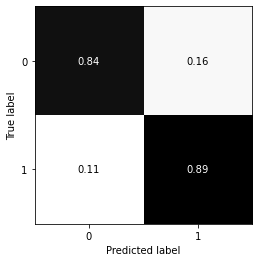

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
print('Accuracy of random forrest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test), display_labels=clf.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

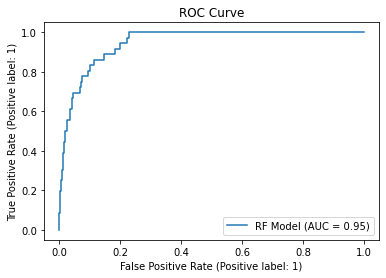

In [41]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(clf, X_test, y_test, name="RF Model")
_ = display.ax_.set_title("ROC Curve")

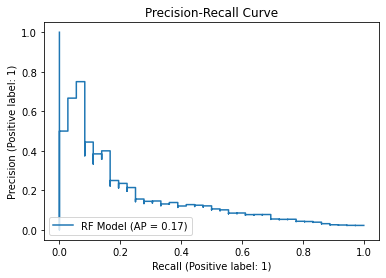

In [42]:
from sklearn.metrics import PrecisionRecallDisplay

y_prob = clf.predict_proba(X_test)
display = PrecisionRecallDisplay.from_predictions(y_test, y_prob[:, 1], name="RF Model")
_ = display.ax_.set_title("Precision-Recall Curve")

Below is a ranked list of the most influential features. Among the most important are the community sizes and the shared ids degree and p2p shared card pageRank.

In [43]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_train, y_train, random_state=0)
pd.DataFrame(abs(result['importances_mean']),index=X_train.columns).sort_values(0, ascending=False)

,0
communitySize,0.106526
partOfCommunity,0.096765
sharedIdsDegree,0.018892
p2pSharedCardPageRank,0.016861
ipDegree,0.008471
cardDegree,0.004484
deviceDegree,0.002431
p2pReceivedWeightedPageRank,0.002268
p2pSentPageRank,0.002031
p2pReceivedWeightedDegree,0.001319


### Investigating Unlabeled High-Probability Fraud Risk Predictions
The labeling from part 2 wasn't perfect. Now that we have trained a machine learning model, investigating user accounts that were predicted as high probability fraud risks despite not being labeled as such by us (ostensible false positives), will bring further insights.

The below commands will isolate some cases from the test set so we can visualize in [Neo4j Bloom](https://neo4j.com/product/bloom/)

In [44]:
# Retrieve High Probability predictions for non-fraud risk labeled data in the testset
y_test_df = y_test.to_frame(name='cls')
y_test_df['predictedProbability']=y_prob[:, 1]
test_prob_df = y_test_df[(y_test_df.predictedProbability > 0.88) & (y_test_df.cls == 0)] \
    .join(df[['guid','wccId', 'communitySize']])
test_prob_df

,cls,predictedProbability,guid,wccId,communitySize
3724,0,0.881712,50ad7d70bb174a8f95d06d5067db1bba,2391,5
10344,0,0.880321,bf39047c8f385a0a6657217c1b052858,363,7
21326,0,0.896839,c4d3c05ebf06a6b7b2f10833a51a0b70,16635,4


In [45]:
#Write back to database for investigation in Bloom
for index, row in test_prob_df.iterrows():
    gds.run_cypher('''
        MATCH(u:User) WHERE u.guid = $guid
        SET u.predictedProbability = $predictedProbability
    ''', params = row.to_dict())

Below are a couple examples from the test set visualized in [Bloom](https://neo4j.com/docs/bloom-user-guide/current/) . The larger, leftmost, green nodes with user icons represent the high probability nodes of interest.

Example 1
<img src="img/predictions-in-bloom-1.png" width="700" >\n

Example 2
<img src="img/predictions-in-bloom-2.png" width="700" >


Perhaps unsurprisingly, they exhibit the P2P with shared card behavior, they also have a relatively large number of credit cards (the median degree centrality on cards is 3). This could potentially be a sign of fraud, though it is hard to know on an anonymized dataset like this. This is where subject matter expert review and iteration comes in. If this behavior turns out to be a clear indicator of fraud, it means we are predicting fraud more proactively before chargebacks take place which is the ideal. In this case, if we re-label these users appropriately and re-train our ML model as more data comes in, we will further improve predictive performance. If, on the other hand, it turns out that some of this behavior is benign, we can adjust the feature engineer and model so the ML learns to rule out such cases which will likewise improve predictive performance and increase our understanding of fraud patterns. Either way, it is a win.

## Clean Up
This section will help clean all the additional graph elements and properties created in the above workflow.

In [46]:
# delete created relationships
gds.run_cypher('MATCH (:User)-[r:SHARED_IDS]->() DELETE r')
gds.run_cypher('MATCH (:User)-[r:P2P_WITH_SHARED_CARD]->() DELETE r')
gds.run_cypher('MATCH (:User)-[r:SIMILAR_IDS]->() DELETE r')

""


In [47]:
# remove created node Labels
gds.run_cypher('MATCH (u:FlaggedUser) REMOVE u:FlaggedUser')
gds.run_cypher('MATCH (u:FraudRiskUser) REMOVE u:FraudRiskUser')
gds.run_cypher('MATCH (u:FraudSharedId) REMOVE u:FraudSharedId')

""


In [48]:
# remove created node properties
gds.run_cypher('''
    MATCH (n)
    REMOVE n.wccId,
        n.sharedIdsDegree,
        n.predictedProbability,
        n.partOfCommunity,
        n.p2pSharedCardPageRank,
        n.p2pSharedCardDegree,
        n.p2pSentWeightedPageRank,
        n.p2pSentWeightedDegree,
        n.p2pSentPageRank,
        n.p2pSentDegree,
        n.p2pReversedSharedCardPageRank,
        n.p2pReversedSharedCardDegree,
        n.p2pReceivedWeightedPageRank,
        n.p2pReceivedWeightedDegree,
        n.p2pReceivedPageRank,
        n.p2pReceivedDegree,
        n.louvainCommunityId,
        n.ipDegree,
        n.fraudRiskRatio,
        n.fraudRiskDegree,
        n.fraudRisk,
        n.flaggedRatio,
        n.flaggedDegree,
        n.deviceDegree,
        n.degree,
        n.communitySize,
        n.cardDegree
''')

""


In [49]:
# remove created relationship properties
gds.run_cypher('MATCH ()-[r]->() REMOVE r.inverseDegreeWeight')

""
